In [2]:
import os
import cv2
import numpy as np
import mrcnn.model as modellib
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
from skimage.color import gray2rgb
from mrcnn import utils
from sklearn.ensemble import RandomForestClassifier
from samples.coco import coco
%matplotlib inline 

Using TensorFlow backend.


In [3]:
# where model and COCO weights are stored
MODEL_PATH = "./logs"
MODEL_WEIGHTS_PATH = "./mask_rcnn_coco.h5"
# where data set is
data_root = "/home/b1deng/228/CUB_200_2011"
# root dir to save images after background removal
dest = "./res"

if not os.path.exists(MODEL_WEIGHTS_PATH):
    utils.download_trained_weights(MODEL_WEIGHTS_PATH)

      
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1  

In [4]:
config = InferenceConfig()
# Create MaskCNN model in inference mode and load weights
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_PATH, config=config)
model.load_weights(MODEL_WEIGHTS_PATH, by_name=True)

In [5]:
# remove background from image
mode = ["train", "test"]

# class id for bird in COCO
bird_id = 15

for m in mode:
    if not os.path.exists(os.path.join(dest, m)):
        os.makedirs(os.path.join(dest, m))

for m in mode:
    src_dir = os.path.join(data_root, m)
    for img in os.listdir(src_dir):
        file_name = img.split('.')[0]
        # read in one image
        image_input = imread(os.path.join(src_dir, img))
        # convert to RGB
        if image_input.ndim == 2:
            image_input = gray2rgb(image_input)
        results = model.detect([image_input])


        # unpack inference results  
        result = results[0]
        masks = result['masks'].astype(np.uint8)
        scores = result['scores']
        rois = result['rois']
        
        # get result index for all regions identified as bird
        idxes = [i for i in range(len(result['class_ids'])) if result['class_ids'][i] == bird_id]
        
        # keep the one with highest confidence
        if len(idxes) > 0:
            idx = idxes[0]
            max_score = scores[idx]

            for index in idxes:
                if scores[index] > max_score:
                    max_score = scores[index]
                    idx = index
                
            # bounding box for the max
            (y1, x1, y2, x2) = rois[idx] 
            width = x2 - x1
            height = y2 - y1
            
            # get mask for the region containing a bird
            bitmap = masks[:,:,idx]   
            bitmap[bitmap > 0] = 255    
            bitmap = np.tile(bitmap[:, :, None], [1, 1, 3])
            
            # save result
            path_output_image = f'{dest}/{m}/{img}'
            image_output = Image.fromarray(np.bitwise_and(image_input, bitmap))
            image_output.save(path_output_image)

In [8]:
# extraact RGB or HSV color feature from image
def extract_hist_feature(img, rgb=True, verbose=False):
    src = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) if not rgb else img
    chans = cv2.split(src)
    colors = ("b", "g", "r")
    name = ['Blue', 'Green', 'Red'] if rgb else ["Hue", "Saturation", "Value"]

    features = []
    
    
    # loop over the image channels
    i = 1
    for (chan, color) in zip(chans, colors):
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        hist = cv2.calcHist([chan], [0], None, [10], [10, 210])
        hist = hist.reshape(-1)
        hist += 1e-5
        features.extend(hist / hist.sum())
        if verbose:
            plt.figure(figsize=(10, 3)) 
            plt.subplot(1, 3, i)
            plt.title(f'{name[i - 1]} Histogram')
            plt.xlabel("Value")
            plt.ylabel("# of Pixels")
            plt.xticks([10 + x * 22 for x in range(10)])
            plt.bar([21 + x * 22 for x in range(10)], hist, width=22, color = color)
            i += 1
            plt.tight_layout()
    return features

In [10]:
train_dir = os.path.join(dest, "train")

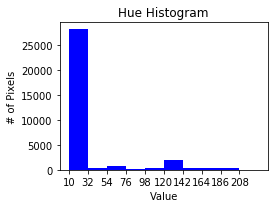

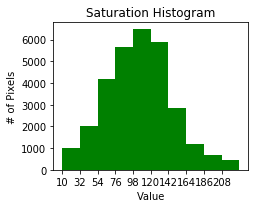

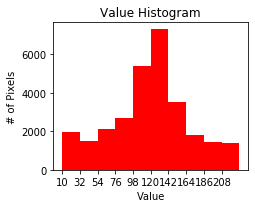

In [75]:
g = extract_hist_feature(cv2.imread(os.path.join(train_dir, '10019.jpg')), verbose=True, rgb=False)

In [6]:
# mapping from image_id to image class
img_id2class = {}
class_file = os.path.join(data_root, 'image_class_labels.txt')
with open(class_file, 'r', encoding='utf-8') as f:
    for line in f:
        img_id, class_id = map(int, line.rstrip().split(' '))
        img_id2class[img_id] = class_id

In [9]:
train_x = []
train_y = []
train_dir = os.path.join(dest, "train")
for img in os.listdir(train_dir):
    img_id = int(img.split(".")[0])
    train_y.append(int(img_id2class[img_id]))
    train_x.append(extract_hist_feature(cv2.imread(os.path.join(train_dir, img)), rgb=False))

In [10]:
classifier = RandomForestClassifier()

In [11]:
classifier.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [12]:
test_x = []
test_y = []
test_dir = os.path.join(dest, "test")
for img in os.listdir(test_dir):
    img_id = int(img.split(".")[0])
    test_y.append(int(img_id2class[img_id]))
    test_x.append(extract_hist_feature(cv2.imread(os.path.join(test_dir, img)), rgb=False))

In [13]:
classifier.score(test_x, test_y)

0.10953878406708595